# Setting

In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import datetime as dt

import gurobipy as gp
from gurobipy import GRB

from gmplot import gmplot
import requests
import polyline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
api_key = 'api_key'

# location of depot
depot_lat = 51.327580
depot_lng = -2.606940

# average service time (mins)
svc = 30  

# speed 30 KM per hour
speed = 50

# Large constant
M = 10000

In [3]:
df = pd.read_csv('test.csv')

In [4]:
df

,JOURNEY_ID,LISTING,ORDER_INDEX,VOLUME,WEIGHT,LAT,LNG,ACTION,CUSTOMER_TIMESLOT_START,CUSTOMER_TIMESLOT_END
0,194333,7985885,1,2994750,180,51.534870,-2.586000,pickup,2023-09-15T10:00:00Z,2023-09-15T16:00:00Z
1,194333,7985885,6,-2994750,-180,51.498838,-2.540213,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
2,194333,8040758,2,6101360,367,51.438089,-2.748221,pickup,2023-09-15T09:00:00Z,2023-09-15T14:00:00Z
3,194333,8040758,7,-6101360,-367,51.435782,-2.761534,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
4,194333,8043966,3,1526040,51,51.327580,-2.872980,pickup,2023-09-15T14:00:00Z,2023-09-15T15:00:00Z
5,194333,8043966,8,-1526040,-51,51.436162,-2.761252,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
6,194333,8049581,4,7350334,348,51.497130,-2.572550,pickup,2023-09-15T07:00:00Z,2023-09-15T08:00:00Z
7,194333,8049581,9,-7350334,-348,51.503330,-2.648020,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
8,194333,8049945,5,1242000,90,51.469130,-2.606940,pickup,2023-09-15T07:00:00Z,2023-09-15T10:00:00Z
9,194333,8049945,10,-1242000,-90,51.368190,-2.912540,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z


# Pre-processing

## Data type

In [4]:
df.dtypes

JOURNEY_ID                   int64
LISTING                      int64
ORDER_INDEX                  int64
VOLUME                       int64
WEIGHT                       int64
LAT                        float64
LNG                        float64
ACTION                      object
CUSTOMER_TIMESLOT_START     object
CUSTOMER_TIMESLOT_END       object
dtype: object

In [5]:
df['CUSTOMER_TIMESLOT_START'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_START'])
df['CUSTOMER_TIMESLOT_END'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_END'])

df['mins_start'] = df['CUSTOMER_TIMESLOT_START'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_START'].dt.minute
df['mins_end'] = df['CUSTOMER_TIMESLOT_END'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_END'].dt.minute

In [6]:
# depends on the data date
today = pd.to_datetime('2023-09-15')

# if the start data is the previous date then repplace with 0
df.loc[df['CUSTOMER_TIMESLOT_START'].dt.date < today, 'mins_start'] = 0

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


## Node sets

In [7]:
order_cnt = int(len(df)/2)

# all nodes including depot
n = [i for i in range(len(df)+2)]

# all pickup points
p_plus = [i for i in range(1, order_cnt+1)]

# all delivery points
p_minus = [i for i in range(order_cnt+1, order_cnt*2+1)]

# set of pickup and delivery points
p = [i for i in range(1, len(df)+1)]

# all departing points
n_plus = [i for i in range(len(df)+1)]

# all arrival points
n_minus = [i for i in range(1, len(df)+2)]

## Travel distance / Travel time

In [8]:
dist = df[['LAT', 'LNG', 'ORDER_INDEX']]

# set depot
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':0}, ignore_index=True)
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':11}, ignore_index=True)

dist = dist.sort_values('ORDER_INDEX')
dist = dist.reset_index(drop=True)

In [8]:
dist

,LAT,LNG,ORDER_INDEX
0,51.327580,-2.606940,0.0
1,51.534870,-2.586000,1.0
2,51.438089,-2.748221,2.0
3,51.327580,-2.872980,3.0
4,51.497130,-2.572550,4.0
5,51.469130,-2.606940,5.0
6,51.498838,-2.540213,6.0
7,51.435782,-2.761534,7.0
8,51.436162,-2.761252,8.0
9,51.503330,-2.648020,9.0


In [9]:
def google_maps_distance(lat1, lon1, lat2, lon2, key):
    
    origin = f"{lat1},{lon1}"
    destination = f"{lat2},{lon2}"
    
    # API request URL
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin}&destinations={destination}&mode=driving&key={api_key}"
    
    # 發送請求
    response = requests.get(url)
    result = response.json()
    
    # 檢查請求狀態
    if result['status'] == 'OK':
        # 獲取行車距離（米）
        distance_meters = result['rows'][0]['elements'][0]['distance']['value']
        # 將距離轉換為公里
        distance_km = distance_meters / 1000.0
        return distance_km
    else:
        raise Exception(f"Error fetching distance from Google Maps API: {result['status']} - {result.get('error_message', '')}")


In [10]:
# travel time (mins)
def travel_time(distance):
    return (distance / speed) * 60 

In [11]:
dist_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])
for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            dist_matrix.loc[i, j] = google_maps_distance(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key)

In [156]:
dist_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,36.015,21.133,21.778,24.938,20.938,27.793,22.465,22.21,26.246,30.398,0.0
1.0,36.42,NaN,20.079,37.807,6.721,10.59,7.375,22.518,22.008,7.887,35.038,36.42
2.0,21.208,20.468,NaN,23.529,19.904,15.741,30.193,1.472,1.217,15.262,20.76,21.208
3.0,21.777,38.221,23.505,NaN,41.977,29.882,47.947,22.816,22.306,33.016,7.322,21.777
4.0,25.103,6.08,23.258,40.985,NaN,4.991,3.722,25.697,25.186,7.162,38.216,25.103
5.0,22.096,9.985,16.359,29.859,5.042,NaN,10.398,17.366,16.855,7.862,32.237,22.096
6.0,28.136,7.569,29.36,47.087,3.734,11.955,NaN,31.798,31.288,10.084,44.318,28.136
7.0,22.521,22.911,1.453,22.823,21.39,17.227,32.637,NaN,0.51,17.706,20.054,22.521
8.0,22.267,22.401,1.199,22.312,20.879,16.716,32.126,0.51,NaN,17.195,19.543,22.267
9.0,27.286,7.995,16.838,34.565,7.461,7.821,10.369,19.277,18.767,NaN,31.797,27.286


In [12]:
time_matrix = dist_matrix.copy() 
for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            time_matrix.loc[i, j] = travel_time(dist_matrix[i][j])

In [157]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,43.704,25.4496,26.1324,30.1236,26.5152,33.7632,27.0252,26.7204,32.7432,36.3756,0.0
1.0,43.218,NaN,24.5616,45.8652,7.296,11.982,9.0828,27.4932,26.8812,9.594,41.7204,43.218
2.0,25.3596,24.0948,NaN,28.206,27.9096,19.6308,35.232,1.7436,1.4388,20.2056,24.06,25.3596
3.0,26.1336,45.3684,28.2348,NaN,49.182,35.8308,56.5044,27.3876,26.7744,41.478,8.7084,26.1336
4.0,29.9256,8.0652,23.8848,50.3724,NaN,6.0504,4.4808,25.668,25.0548,8.9532,46.2276,29.9256
5.0,25.1256,12.708,18.8892,35.8584,5.9892,NaN,14.346,20.6724,20.0592,9.3852,38.76,25.1256
6.0,33.3516,8.85,36.2316,57.5364,4.4664,12.4776,NaN,39.1644,38.5512,12.4428,53.3916,33.3516
7.0,26.958,27.0216,1.7664,27.3792,30.8364,20.8392,38.1576,NaN,0.612,23.1324,23.2344,26.958
8.0,26.652,26.4096,1.4604,26.7672,30.2232,20.226,37.5456,0.612,NaN,22.5204,22.6224,26.652
9.0,31.4952,9.4644,18.3144,39.6192,8.5944,9.4344,12.1008,21.2472,20.634,NaN,35.4744,31.4952


## Time window

In [13]:
tw = df[['mins_start', 'mins_end', 'ORDER_INDEX']]
tw.rename(columns={'mins_start':'a', 'mins_end':'b'}, inplace=True)

# set depot
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':0}, ignore_index=True)
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':11}, ignore_index=True)

tw = tw.sort_values('ORDER_INDEX')
tw = tw.reset_index(drop=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
tw

,a,b,ORDER_INDEX
0,0,1379,0
1,600,960,1
2,540,840,2
3,840,900,3
4,420,480,4
5,420,600,5
6,0,1379,6
7,0,1379,7
8,0,1379,8
9,0,1379,9


# Optimisation

## Problem

In [15]:
prob = gp.Model("Min_Z")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-17


## Variables

In [16]:
x = prob.addVars(n, n, vtype=GRB.BINARY, name='x')

z = prob.addVar(lb=0, vtype=GRB.CONTINUOUS, name='z')

ta = prob.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ta')    # time arriving to the point
ts = prob.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ts')    # time starting to service

late = prob.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='late')

total_penalty = prob.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_penalty')
total_dist = prob.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_dist')

# late_a = prob.addVars(len(n), vtype=GRB.BINARY, name='late_a')   # whether arrival time later than late time window

## Objective function

eq1, eq2

In [17]:
prob.ModelSense = GRB.MINIMIZE
prob.setObjectiveN(z, 0, 1)
prob.setObjectiveN(total_dist, 1, 0)

In [44]:
# select the shortest path with the same z value
# prob.setObjective(M * z + total_dist, GRB.MINIMIZE)

In [18]:
prob.addConstr(total_dist == gp.quicksum(x[i, j] * dist_matrix[i][j] for i in p for j in p if i != j))

<gurobi.Constr *Awaiting Model Update*>

## Constraints

### Cost

In [19]:
def penalty_late(time_diff):
    return 0.2 * time_diff

eq3

In [20]:
prob.addConstrs((late[i] >= (ta[i] - tw['b'][i]) for i in p), name='eq18')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

eq3

In [21]:
total_penalty = gp.quicksum(penalty_late(late[i]) for i in p)
prob.addConstrs((z >= late[i] + late[i+order_cnt] + total_penalty for i in p_plus), name='eq3')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

### Path

eq4, eq5, eq6, eq7, eq8, eq9

In [22]:
prob.addConstrs((gp.quicksum(x[i, j] for j in n_minus if i != j) == 1 for i in n_plus), name='eq4')
prob.addConstrs((gp.quicksum(x[i, j] for i in n_plus if i != j) == 1 for j in n_minus), name='eq5')

prob.addConstr((gp.quicksum(x[0, j] for j in p_plus) == 1), name='eq6')
prob.addConstr((gp.quicksum(x[i, len(n_plus)] for i in p_minus) == 1), name='eq7')

prob.addConstr((gp.quicksum(x[i, 0] for i in n_minus) == 0), name='eq8')
prob.addConstr((gp.quicksum(x[len(n_plus), i] for i in n_plus) == 0), name='eq9')

<gurobi.Constr *Awaiting Model Update*>

### Precedence

eq10

In [23]:
prob.addConstrs((ta[i] + svc + time_matrix[i][i + order_cnt] <= ta[i + order_cnt] for i in p_plus), name='eq10')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

eq11, eq12, eq17

In [24]:
prob.addConstrs((ts[0] + time_matrix[0][j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq12')
prob.addConstrs((ts[0] + time_matrix[0][j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq12')

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

In [25]:
prob.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq11')
prob.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq11')

{(1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7): <gurobi.Constr *Awaiting Model Update*>,
 (2, 8): <gurobi.Constr *Awaiting Model Update*>,
 (2, 9): <gurobi.Constr *Awaiting Model Update*>,
 (2, 10): <gurobi.Constr *Awaiting Model Update*>,
 (2, 11): <gurobi.Constr *Awaiting Model Update

In [26]:
prob.addConstrs((ts[i] == gp.max_([tw['a'][i], ta[i]]) for i in p), name='eq17')

{1: <gurobi.GenConstr *Awaiting Model Update*>,
 2: <gurobi.GenConstr *Awaiting Model Update*>,
 3: <gurobi.GenConstr *Awaiting Model Update*>,
 4: <gurobi.GenConstr *Awaiting Model Update*>,
 5: <gurobi.GenConstr *Awaiting Model Update*>,
 6: <gurobi.GenConstr *Awaiting Model Update*>,
 7: <gurobi.GenConstr *Awaiting Model Update*>,
 8: <gurobi.GenConstr *Awaiting Model Update*>,
 9: <gurobi.GenConstr *Awaiting Model Update*>,
 10: <gurobi.GenConstr *Awaiting Model Update*>}

In [405]:
# prob.addConstrs((ts[i] >= ta[i] for i in p), name='eq17')
# prob.addConstrs((ts[i] >= tw['a'][i] for i in p), name='eq17')

In [406]:
# prob.addConstrs((tw['a'][i] - ta[i] <= M * (1 - late_a[i]) for i in p), name='eq17')
# prob.addConstrs((tw['a'][i] - ta[i] >= (-M * late_a[i]) for i in p), name='eq17')

# prob.addConstrs((ts[i] >= ta[i] - M * (1 - late_a[i]) for i in p), name='eq17')
# prob.addConstrs((ts[i] <= ta[i] + M * (1 - late_a[i]) for i in p), name='eq17')
# prob.addConstrs((ts[i] >= tw['a'][i] - M * late_a[i] for i in p), name='eq17')
# prob.addConstrs((ts[i] <= tw['a'][i] + M * late_a[i] for i in p), name='eq17')

In [390]:
constraints = prob.getConstrs()

for constr in constraints:
    print(f"约束名称: {constr.ConstrName}")
    print(f"约束表达式: {prob.getRow(constr)}")
    print(f"右边值: {constr.RHS}")
    print()

约束名称: R0
约束表达式: -20.468 x[1,2] + -38.221 x[1,3] + -6.08 x[1,4] + -9.985 x[1,5] + -7.569 x[1,6] + -22.911 x[1,7] + -22.401 x[1,8] + -7.995 x[1,9] + -34.767 x[1,10] + -20.079 x[2,1] + -23.505 x[2,3] + -23.258 x[2,4] + -16.359 x[2,5] + -29.36 x[2,6] + -1.453 x[2,7] + -1.199 x[2,8] + -16.838 x[2,9] + -20.05 x[2,10] + -37.807 x[3,1] + -23.529 x[3,2] + -40.985 x[3,4] + -29.859 x[3,5] + -47.087 x[3,6] + -22.823 x[3,7] + -22.312 x[3,8] + -34.565 x[3,9] + -7.257 x[3,10] + -6.721 x[4,1] + -19.904 x[4,2] + -41.977 x[4,3] + -5.042 x[4,5] + -3.734 x[4,6] + -21.39 x[4,7] + -20.879 x[4,8] + -7.461 x[4,9] + -38.523 x[4,10] + -10.59 x[5,1] + -15.741 x[5,2] + -29.882 x[5,3] + -4.991 x[5,4] + -11.955 x[5,6] + -17.227 x[5,7] + -16.716 x[5,8] + -7.821 x[5,9] + -32.3 x[5,10] + -7.375 x[6,1] + -30.193 x[6,2] + -47.947 x[6,3] + -3.722 x[6,4] + -10.398 x[6,5] + -32.637 x[6,7] + -32.126 x[6,8] + -10.369 x[6,9] + -44.493 x[6,10] + -22.518 x[7,1] + -1.472 x[7,2] + -22.816 x[7,3] + -25.697 x[7,4] + -17.366 x[7,5] 

# Solution

In [27]:
prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 257 rows, 183 columns and 1060 nonzeros
Model fingerprint: 0xdc040a25
Model has 10 general constraints
Variable types: 39 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon const rng [4e+02, 8e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 10 rows and 0 columns
Presolve removed 0 rows and 23 columns
Presolve time: 0.03s
Presolved: 267 rows a

In [28]:
if prob.status == GRB.Status.OPTIMAL:
    print("Optimal value of z:", z.X)
else:
    print("No optimal solution found.")

Optimal value of z: 1.0001e-06


In [29]:
if prob.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 5, 4, 1, 6, 9, 2, 10, 3, 8, 7, 11]


In [58]:
best_route

[0, 5, 4, 1, 6, 9, 2, 7, 10, 3, 8, 11]

In [ ]:
if prob.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 5, 4, 1, 6, 9, 2, 10, 3, 8, 7, 11]


In [30]:
ta_values = [ta[i].X for i in best_route]
ts_values = [ts[i].X for i in best_route]
late_values = [late[i].X for i in best_route]


result_df = pd.DataFrame({
    "Point": best_route,
    "ta": ta_values,
    "ts": ts_values,
    "late": late_values
})

In [31]:
result_df

,Point,ta,ts,late
0,0,0.0000,0.0000,0.000000e+00
1,5,25.1256,420.0000,0.000000e+00
2,4,456.0504,456.0504,0.000000e+00
3,1,493.3464,600.0000,0.000000e+00
4,6,638.8500,638.8500,0.000000e+00
5,9,680.9508,680.9508,0.000000e+00
6,2,731.1564,731.1564,0.000000e+00
7,10,786.0684,786.0684,0.000000e+00
8,3,824.7768,840.0000,8.334167e-07
9,8,896.7672,896.7672,0.000000e+00


# Visualisation

## optimal result

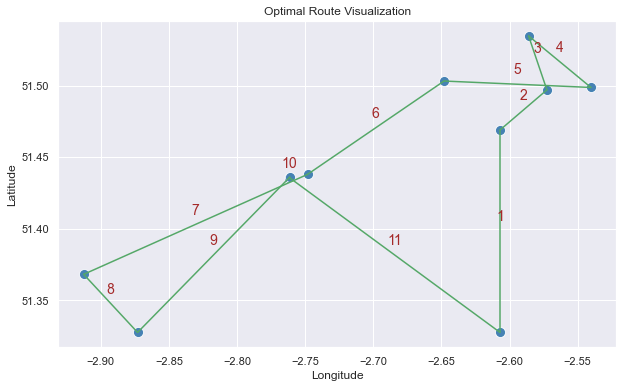

In [191]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')


# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     if i == 7:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
#     elif i == 8:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
#     elif i == 11:
#         plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
#     else:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


# Plotting the route
# for i in range(len(best_route) - 1):
#     start_point = best_route[i]
#     end_point = best_route[i + 1]
#     plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')



# Plotting the route
for i in range(len(best_route) - 1):
    start_point = best_route[i]
    end_point = best_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color='brown')



plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

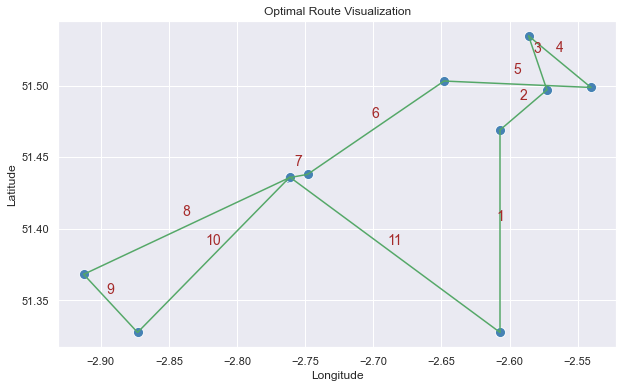

In [ ]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')


# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     if i == 7:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
#     elif i == 8:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
#     elif i == 11:
#         plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
#     else:
#         plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


# Plotting the route
# for i in range(len(best_route) - 1):
#     start_point = best_route[i]
#     end_point = best_route[i + 1]
#     plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')



# Plotting the route
for i in range(len(best_route) - 1):
    start_point = best_route[i]
    end_point = best_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color='brown')



plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Original result

In [59]:
ori_route = [0, 5, 4, 9, 2, 7, 3, 10, 8, 1, 6, 11]

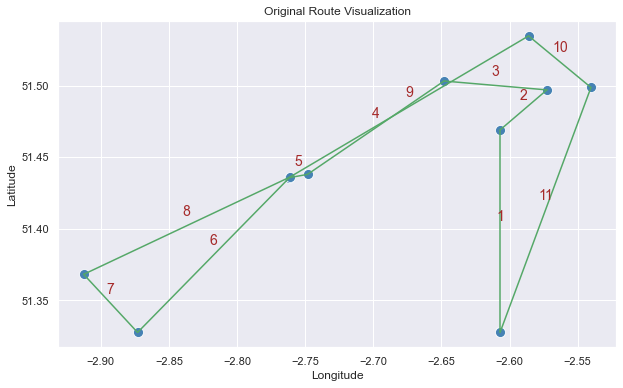

In [60]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')


# Plotting the route
for i in range(len(ori_route) - 1):
    start_point = ori_route[i]
    end_point = ori_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color='brown')



plt.title('Original Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Results on Google map

In [157]:
file_name = 'optimized_route_map_gmap.html'

In [158]:
latitude_list = dist['LAT'].tolist()
longitude_list = dist['LNG'].tolist()

best_route_latitudes = [latitude_list[i] for i in best_route]
best_route_longitudes = [longitude_list[i] for i in best_route]

# setting size
gmap = gmplot.GoogleMapPlotter(51.45, -2.60, 10, apikey=api_key)

# plot all points
gmap.scatter(latitude_list, longitude_list, 'lightcoral', size=40, marker=True)

# travelling path on google map
for idx in range(len(best_route) - 1):
    start = f"{latitude_list[best_route[idx]]},{longitude_list[best_route[idx]]}"
    end = f"{latitude_list[best_route[idx + 1]]},{longitude_list[best_route[idx + 1]]}"
    url = f"https://maps.googleapis.com/maps/api/directions/json?origin={start}&destination={end}&key={api_key}"
    
    response = requests.get(url)
    directions = response.json()
    
    # ensure request successful
    if directions['status'] == 'OK':
        route = directions['routes'][0]['overview_polyline']['points']
        decoded_route = polyline.decode(route)
        latitudes, longitudes = zip(*decoded_route)
        gmap.plot(latitudes, longitudes, 'blue', edge_width=4)
    else:
        print(f"Error fetching directions between {start} and {end}: {directions['status']}")

# save the map
gmap.draw(file_name)